## Plot model performance

Visualize performance on different models from a CSV summary file.

In [6]:
import pathlib
import itertools

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import BodeColorPalette
bode_palette = BodeColorPalette()

### Get data from wandb CSV export
Here we read the results file to plot the results.

In [7]:
# settings
sns.set_theme(context="paper", 
              style="white", 
              font_scale=0.7,
              rc={"savefig.transparent": True, 
                  "axes.grid": False, 
                  "axes.spines.bottom": True,
                  "axes.spines.left": False,
                  "axes.spines.right": False,
                  "axes.spines.top": False,
                  "font.family":'sans-serif',
                  #"font.sans-serif":["Helvetica", "Arial"],
                  "xtick.major.pad": 0.0,
                  "xtick.minor.pad": 0.0,
                  "ytick.major.pad": 0.0,
                  "ytick.minor.pad": 0.0,
                  "axes.labelweight": "bold",
                  "axes.labelpad": 2.5,  # standard is 4.0
                  "axes.xmargin": .05,
                 }, 
             )

# more settings for all plots
errorbar = "se"  # standard error of the mean
errwidth = .9
errcolor = "black"
capsize = .1  # size of the end of the errorbar
linewidth = 1.  # width of the outline of barplot

palette = [
    bode_palette.blues[0], 
    bode_palette.oranges[0],
    bode_palette.blues[2],
    bode_palette.oranges[2],
    bode_palette.blues[3],
    bode_palette.oranges[3]
]

# data (from file)
analysis_dir = pathlib.Path(".")
results_file = analysis_dir / "results_summary.csv"
results_file_all = analysis_dir/ "results_all.csv"

df_summary = pd.read_csv(results_file, header=[0, 1], index_col=[0, 1])
df_all = pd.read_csv(results_file_all, index_col=0)

df_all["Model+Features"] = df_all["name"] + "\n" + df_all["decoder.global_features"].str.strip('[""]')
df_all["name"] = df_all.index.values  # duplicate index into column b/c we will need to apply a function for selecting rows.

## 0D split

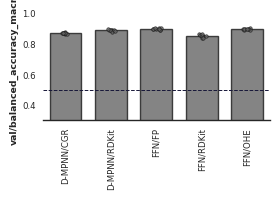

In [38]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/balanced_accuracy_macro"
# choose the task (0D, 1D, or 2D)
tag = "0D"
# choose the colorscheme
fill_color = '0.4'  # grey
stroke_color = '0.1'  # almost black

# choose the data to plot
run_groups = [
    "2023-09-23-000628_941876",
    "2023-09-23-025934_146143",
    "2023-09-24-175610_511580",
    "2023-09-24-162517_327706",
    "2023-09-24-155637_396648",
]
ticklabels = ["D-MPNN/CGR", "D-MPNN/RDKit", "FFN/FP", "FFN/RDKit", "FFN/OHE"]

# filter the data
df_plot = df_all.loc[df_all['name'].apply(lambda x: any(x.startswith(q) for q in run_groups)),  ["Model+Features", metric]]

# sort the values
sort_dict = dict(zip(include_list, itertools.count()))
df_plot = df_plot.sort_values(by="Model+Features", kind="mergesort", key=lambda x: x.map(sort_dict))

# set plot
fig, ax = plt.subplots(figsize=(2.8,2))
sns.barplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    errorbar=errorbar,
    errwidth=errwidth,
    errcolor=errcolor,
    capsize=capsize,
    color=fill_color,
    edgecolor=stroke_color,
    linewidth=linewidth,
    alpha=.8,
    width=.7,
)

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=2.5,
              alpha=.8
             )

ax.axhline(0.5, ls="--", color=bode_palette.blue, linewidth=.7)
ax.set_xlabel(None)
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.3, 1.0))
ax.xaxis.set_ticklabels(ticklabels)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.png", dpi=300)

In [37]:
[print(i) for i in df_plot.index.map(lambda x: x.rsplit("_", maxsplit=1)[0]).unique()]

2023-09-26-101818_629117
2023-09-24-091951_200593
2023-09-23-000628_941876
2023-09-22-212923_996081
2023-09-23-025934_146143
2023-09-24-175610_511580
2023-09-24-162517_327706
2023-09-26-120139_108981
2023-09-24-155637_396648


[None, None, None, None, None, None, None, None, None]

## 1D split

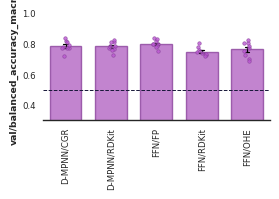

In [24]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/balanced_accuracy_macro"
# choose the task (0D, 1D, or 2D)
tag = "1D"
# choose the colorscheme
fill_color = (189/256, 87/256, 213/256)
stroke_color = (140/256, 67/256, 158/256)

# choose the data to plot
run_groups = [
    "2023-09-24-104146_718231",
    "2023-09-24-111906_946206",
    "2023-09-24-181851_729257",
    "2023-09-24-171831_775330",
    "2023-09-25-000626_212529",
]
ticklabels = ["D-MPNN/CGR", "D-MPNN/RDKit", "FFN/FP", "FFN/RDKit", "FFN/OHE"]


# filter the data
df_plot = df_all.loc[df_all['name'].apply(lambda x: any(x.startswith(q) for q in run_groups)),  ["Model+Features", metric]]

# sort the values
sort_dict = dict(zip(include_list, itertools.count()))
df_plot = df_plot.sort_values(by="Model+Features", kind="mergesort", key=lambda x: x.map(sort_dict))

# set plot
fig, ax = plt.subplots(figsize=(2.8,2))
sns.barplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    errorbar=errorbar,
    errwidth=errwidth,
    errcolor=errcolor,
    capsize=capsize,
    color=fill_color,
    edgecolor=stroke_color,
    linewidth=linewidth,
    alpha=.8,
    width=.7,
)

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=2.5,
              alpha=.8
             )

ax.axhline(0.5, ls="--", color=bode_palette.blue, linewidth=.7)
ax.set_xlabel(None)
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.3, 1.0))
ax.xaxis.set_ticklabels(ticklabels)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.png", dpi=300)

## 2D split

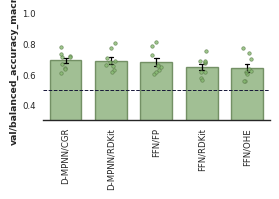

In [21]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/balanced_accuracy_macro"
# choose the task (0D, 1D, or 2D)
tag = "2D"
# choose the colorscheme
fill_color = (
    135/256,
    186/256,
    112/256,
)

stroke_color = (92/256, 124/256, 76/256)

# choose the data to plot
run_groups = [
    "2023-09-24-110147_836449",
    "2023-09-24-113901_714036",
    "2023-09-24-182958_465266",
    "2023-09-24-173355_686645",
    "2023-09-25-002735_600282",
]
ticklabels = ["D-MPNN/CGR", "D-MPNN/RDKit", "FFN/FP", "FFN/RDKit", "FFN/OHE"]


# filter the data
df_plot = df_all.loc[df_all['name'].apply(lambda x: any(x.startswith(q) for q in run_groups)),  ["Model+Features", metric]]
# sort the values
sort_dict = dict(zip(include_list, itertools.count()))
df_plot = df_plot.sort_values(by="Model+Features", kind="mergesort", key=lambda x: x.map(sort_dict))

# set plot
fig, ax = plt.subplots(figsize=(2.8,2))
sns.barplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    errorbar=errorbar,
    errwidth=errwidth,
    errcolor=errcolor,
    capsize=capsize,
    color=fill_color,
    edgecolor=stroke_color,
    linewidth=linewidth,
    alpha=.8,
    width=.7,
)

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=2.5,
              alpha=.8
             )

ax.axhline(0.5, ls="--", color=bode_palette.blue, linewidth=.7)
ax.set_xlabel(None)
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.3, 1.0))
ax.xaxis.set_ticklabels(ticklabels)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.png", dpi=300)

## 3D split

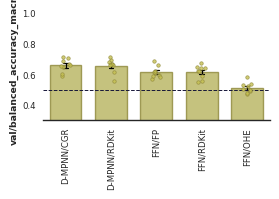

In [39]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/balanced_accuracy_macro"
# choose the task (0D, 1D, or 2D)
tag = "3D"
# choose the colorscheme
fill_color = (198/256, 193/256, 80/256)

stroke_color = (142/256, 136/256, 58/256)

# choose the data to plot
run_groups = [
    "2023-09-26-114651_772025",
    "2023-09-24-115110_933630",
    "2023-09-24-183739_809632",
    "2023-09-24-174317_913810",
    "2023-09-26-132606_155550",
]
ticklabels = ["D-MPNN/CGR", "D-MPNN/RDKit", "FFN/FP", "FFN/RDKit", "FFN/OHE"]


# filter the data
df_plot = df_all.loc[df_all['name'].apply(lambda x: any(x.startswith(q) for q in run_groups)),  ["Model+Features", metric]]
# sort the values
sort_dict = dict(zip(include_list, itertools.count()))
df_plot = df_plot.sort_values(by="Model+Features", kind="mergesort", key=lambda x: x.map(sort_dict))

# set plot
fig, ax = plt.subplots(figsize=(2.8,2))
sns.barplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    errorbar=errorbar,
    errwidth=errwidth,
    errcolor=errcolor,
    capsize=capsize,
    color=fill_color,
    edgecolor=stroke_color,
    linewidth=linewidth,
    alpha=.8,
    width=.7,
)

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=2.5,
              alpha=.8
             )

ax.axhline(0.5, ls="--", color=bode_palette.blue, linewidth=.7)
ax.set_xlabel(None)
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.3, 1.0))
ax.xaxis.set_ticklabels(ticklabels)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.png", dpi=300)